# Tensor Flow Example

Import and setup the Intelligent Plant clients

In [1]:
import intelligent_plant.app_store_client as app_store_client
import os
app_store = app_store_client.AppStoreClient(os.environ["ACCESS_TOKEN"])
data_core = app_store.get_data_core_client()

In [2]:
import intelligent_plant.utility as utility
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns

Import Tensorflow and the keras API

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Look up the fully qualified names of authorised data sources.

Check that 'IP Datasource 2' appears in this list for you.

In [4]:
list(map(lambda x: x['Name']['QualifiedName'], data_core.get_data_sources(["*"])))

['IP Datasource', 'IP Datasource 2', 'Vibration']

We can use the data core client to query IP Datasource

This code will page through every tag on the datasource and add it to a list. Note: on a real data source this would be a very expensive operation and is not advised. A much better approach would be to only query tags relevant to the problem you are trying to solve.

For each of the tags in the demo data source (~100) query for data at 10 minute intervals for the past 30 days. This will form our training and testing data.

In [5]:
dsn = "IP Datasource 2"
tags = []

page_size = 50
page_num = 1
while True:
    page = data_core.get_tags(dsn, page_num, page_size)
    
    #append the page just fetched into the list of all tags
    tags += page
    
    page_num += 1
    
    #if a page is shorter than the page size requested it is the last page
    if (len(page) < page_size):
        break

#map tages meta data to only be tag name and filter out the "TIME" tag
tag_names = list(filter(lambda x: x != "TIME", map(lambda x: x["Id"], tags)))
all_data = data_core.get_processed_data({dsn: tag_names}, '*-30d', '*', '10m', 'interp')

We can convert the result data to a data frame

In [6]:
df = utility.query_result_to_data_frame(all_data)

Remove the timestamp column

In [7]:
del df['TimeStamp']

Pick a tag as output from the tag list to test against

In [8]:
df.columns

Index(['T2 MPGC 2nd Stg Suct Scrubber_PI', 'T1 MPGC 1st Stg Suct Scrubber_PI',
       'CALC_Scaled_HP Flare Header Wet_PI', 'LP FG Header_PI',
       'MeOH Surge Vessel_PI', 'Demulsifier L.P. Inj Pump B_PI',
       'FG Filter B_PI', 'Corrosion Inhibitor HP Inj Pump B_PI',
       'Biocide (Oil) Inj Pump A_PI', 'T2 MPGC 1st Stg_Disc_PI',
       ...
       'WI Pump B_Suct_PI', 'Polyelectrolyte_1 Inj Pump A_PI',
       'SRP Feed Pump C_PI', 'LP Degasser_PI', 'PCM Drum_PI',
       'Coagulant Inj Pump A_PI', 'Sand Hydrocyclone_PI', 'HP FG Scrubber_PI',
       'Prod Riser Depress Heater_TS Out_PI',
       'LP Flare KO Drum Pump C_Disc_PI'],
      dtype='object', length=113)

In [9]:
tag_to_predict = 'LP Flare KO Drum Pump C_Disc_PI'

Take a random sample as training data and the rest can be test data

In [10]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

Take the tag to predict column and seperate it out

In [11]:
train_output = train_dataset.pop(tag_to_predict)
test_output = test_dataset.pop(tag_to_predict)

Get some descriptive information about the input data.

We can use the mean and standrad deviation to normalise the data.

In [12]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

We can define a model using the Keras API. A sequential model is one where the output of each layer is sequentially fed into the input of the next.

Here I have used a couple of dense neural network layers and the "relu" activation function. The last layer is not "relu" as the output should be between 0 and 1.

This is just an example and may not be the best solution to this problem.

Feel free to make a copy of this notebook and change the sizes, number and types of layers to see how that effects the results.

In [13]:
model = keras.models.Sequential([
    layers.Dense(512, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
], "DemoNN")

Compiling the network get's it into a state where it's ready to be trained.

Here we select the loss function, the optimzer algorithm and the metrics.

In [14]:
model.compile(loss='mean_absolute_error',
                optimizer="adam",
                metrics=['mean_absolute_error', 'mean_squared_error'])

Calling `model.summary()` outputs a table showing all the layers in the neural network

In [15]:
model.summary()

Model: "DemoNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               57856     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 90,753
Trainable params: 90,753
Non-trainable params: 0
_________________________________________________________________


The `model.fit()` function can be used to train the neural network on the provided data.

The `epochs` parameter defines how man iterations through the training set we will use and the `validation_split` parameter determines how much of the training data will be used for validation.

In [16]:
history = model.fit(normed_train_data, train_output, epochs=20, validation_split = 0.2)

Train on 2765 samples, validate on 692 samples
Epoch 1/20
2765/2765 [==============================] - 0s 99us/sample - loss: 0.1482 - mean_absolute_error: 0.1482 - mean_squared_error: 0.0527 - val_loss: 0.0877 - val_mean_absolute_error: 0.0877 - val_mean_squared_error: 0.0141
Epoch 2/20
2765/2765 [==============================] - 0s 62us/sample - loss: 0.0641 - mean_absolute_error: 0.0641 - mean_squared_error: 0.0073 - val_loss: 0.0555 - val_mean_absolute_error: 0.0555 - val_mean_squared_error: 0.0067
Epoch 3/20
2765/2765 [==============================] - 0s 60us/sample - loss: 0.0413 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0031 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382 - val_mean_squared_error: 0.0024
Epoch 4/20
2765/2765 [==============================] - 0s 65us/sample - loss: 0.0356 - mean_absolute_error: 0.0356 - mean_squared_error: 0.0022 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291 - val_mean_squared_error: 0.0019
Epoch 5/20
2765/2765 [=======

We can use the history object returned from the training step to visualise the training process.

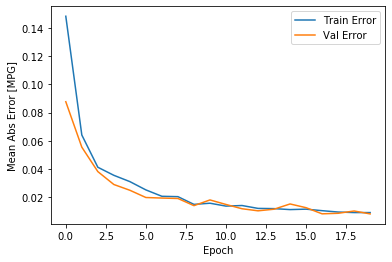

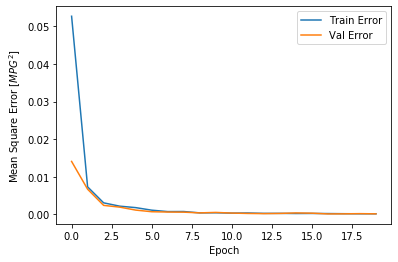

In [17]:
def plot_history(history):
    hist = DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)


Each of these graphs is similar but they are showing differnet metrics for the neural netoworks error.

You can see that in both graphs the neural network initally shraply decreases in error and then levels off.

If the validation error (orange) is much greater then the training error (blue) that indicates overfitting. The neural network is now only getting better at instances it's seen before and won't generalise well to unseen data.

The `model.evaluate(..)` function can be used to gernerate metrics about the performance of the neural net on the unseen test data.

This is useful to tell if the neural net is generalising well.

In [18]:
model.evaluate(normed_test_data, test_output)

864/864 [==============================] - 0s 20us/sample - loss: 0.0081 - mean_absolute_error: 0.0081 - mean_squared_error: 1.2641e-04


[0.00807883833638496, 0.008078839, 0.00012640687]

The `model.predict(..)` function will run the provided input through the network and return the networks prediction for those input values.

In [19]:
prediction = model.predict(normed_test_data).flatten()

Putting this prediction into a dataframe allows us to plot the rediction versus the actual value in order to compare them.

In [20]:
prediction_df = DataFrame({ "actual": test_output, "prediction": prediction })

We can use seaborn to generate a scatter plot of the models prediction against the known ground truth.

Ideally, a perfect result would create a straight line of x = y. Any deviation from that line is error in the model.

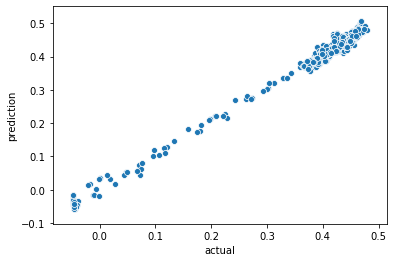

In [21]:
sns.scatterplot(prediction_df['actual'], prediction_df['prediction'])

This notebook is adapted from the tensor flow basic regression tutorial

https://www.tensorflow.org/tutorials/keras/basic_regression